<a href="https://colab.research.google.com/github/adnaneaabbar/car-detection/blob/master/Autonomous_Driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries


In [0]:
import sys
sys.path.append("/car-detection/")
import argparse
import os
from matplotlib.pyplot import imshow
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt

%matplotlib inline

c:\users\aabba\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\aabba\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\aabba\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\aabba\appd

In [0]:
print(tf.__version__)

1.14.0


## 1 - Problem Statement

We are working on a self-driving car. As a critical component of this project, we'd like to first build a car detection system. To collect data, we've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while we drive around. 

Road video can be found at [road_video.mp4](https://github.com/adnaneaabbar/car-detection/tree/master/assets/videos/road_video.mp4)

Dataset provided by : ![drive.ai](https://github.com/adnaneaabbar/car-detection/tree/master/assets/images/driveai.png)

Definition of a box: ![box_label](https://github.com/adnaneaabbar/car-detection/tree/master/assets/images/box_label.png)

We will learn how "You Only Look Once" (YOLO) performs object detection, and then apply it to car detection. Because the YOLO model is very computationally expensive to train, we will load pre-trained weights.

## 2 - YOLO

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 2.1 - Model details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If we expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for us (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  



If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

#### Class score

Now, for each box (of each cell) we will compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

Class score : ![Probability Extraction](https://github.com/adnaneaabbar/car-detection/blob/master/assets/images/probability_extraction.png)>



#### Non-Max suppression
We may end up with boxes for which the model had assigned a high probability, but this is still too many boxes. We'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, we'll use **non-max suppression**. Specifically, we'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class; either due to the low probability of any object, or low probability of this particular class).
- Select only one box when several boxes overlap with each other and detect the same object.



### 2.2 - Filtering with a threshold on class scores

We are going to first apply a filter by thresholding. We would like to get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives us a total of 19x19x5x85 numbers, with each box described by 85 numbers. It is convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.
.   

    **Useful reference**:
    * [boolean mask](https://www.tensorflow.org/api_docs/python/tf/boolean_mask)  





In [0]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because we don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes we want to keep (with probability >= threshold)
    filtering_mask = K.greater_equal(box_class_scores, threshold)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

**Note** In the test for `yolo_filter_boxes`, we're using random numbers to test the function.  In real data, the `box_class_probs` would contain non-zero values between 0 and 1 for the probabilities.  The box coordinates in `boxes` would also be chosen so that lengths and heights are non-negative.

### 2.3 - Non-max suppression ###

Even after filtering by thresholding over the class scores, we still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

Non-max suppression : ![Non-max suppression](https://github.com/adnaneaabbar/car-detection/blob/master/assets/images/non-max-suppression.png)
In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes.

Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
IoU : ![Non-max suppression](https://github.com/adnaneaabbar/car-detection/blob/master/assets/images/iou.png)



In [0]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = np.maximum(box1_x1, box2_x1)
    yi1 = np.maximum(box1_y1, box2_y1)
    xi2 = np.minimum(box1_x2, box2_x2)
    yi2 = np.minimum(box1_y2, box2_y2)
    inter_width = xi2 - xi1
    inter_height = yi2 - yi1
    inter_area = inter_width * inter_height
    if box1_x2 < box2_x1 or box2_x2 < box1_x1 or box1_y2 < box1_y1 or box2_y2 < box1_y1:
        inter_area = 0

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_y2 - box1_y1)*(box1_x2- box1_x1)
    box2_area = (box2_y2 - box2_y1)*(box2_x2- box2_x1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

#### YOLO non-max suppression

We are now ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
3. Go back to step 1 and iterate until there are no more boxes with a lower score than the currently selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

** Reference documentation ** 

- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
```
tf.image.non_max_suppression(
    boxes,
    scores,
    max_output_size,
    iou_threshold=0.5,
    name=None
)
```

- [K.gather()](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gather)  
Even though the documentation shows `tf.keras.backend.gather()`, we can use `keras.gather()`.  
```
keras.gather(
    reference,
    indices
)
```

In [0]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes we'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes we keep
    nms_indices = tf.image.non_max_suppression(
                      boxes,
                      scores,
                      max_boxes_tensor,
                      iou_threshold = iou_threshold
                    )
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

### 2.4 Wrapping up the filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions we've just implemented. 

We will Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail we have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which we have provided): 

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```
YOLO's network was trained to run on 608x608 images. If we are testing this data on a different size image--for example, the car detection dataset had 720x1280 images--this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

In [0]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    
    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold 
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    
    
    return scores, boxes, classes

## Summary for YOLO:
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- we then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives us YOLO's final output. 

## 3 - Test YOLO pre-trained model on images

In this part, we are going to use a pre-trained model and test it on the car detection dataset.  We'll need a session to execute the computation graph and evaluate the tensors.

In [0]:
sess = K.get_session()

### 3.1 - Defining classes, anchors and image shape.

* Recall that we are trying to detect 80 classes, and are using 5 anchor boxes. 
* We have gathered the information on the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt". 
* We'll read class names and anchors from text files.
* The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images. 

In [0]:
class_names = read_classes("/car-detection/model_data/coco_classes.txt")
anchors = read_anchors("/car-detection/model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

### 3.2 - Loading a pre-trained model

* Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. 
* We are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5", which can be found in [yolo.h5](https://www.kaggle.com/rmoharir8396/yolo-h5-file). 
* These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but we will simply refer to it as "YOLO" in this notebook.


In [0]:
yolo_model = load_model("/car-detection/model_data/yolo-h5-file/yolo.h5")

c:\users\aabba\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


This loads the weights of a trained YOLO model. Here's a summary of the layers our model contains.

In [0]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

**Reminder**: this model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85).

### 3.3 - Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. The following cell does that.

Curious about how `yolo_head` is implemented, find the function definition in the file ['keras_yolo.py'](https://github.com/adnaneaabbar/car-detection/blob/master/yad2k/models/keras_yolo.py).

In [0]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
print(yolo_outputs[0])
print(yolo_outputs[1])
print(yolo_outputs[2])
print(yolo_outputs[3])
yolo_outputs2 = tuple((yolo_outputs[2], yolo_outputs[0], yolo_outputs[1], yolo_outputs[3]))
print(yolo_outputs2[0])
print(yolo_outputs2[1])
print(yolo_outputs2[2])
print(yolo_outputs2[3])


Tensor("truediv_8:0", shape=(?, ?, ?, 5, 2), dtype=float32)
Tensor("truediv_9:0", shape=(?, ?, ?, 5, 2), dtype=float32)
Tensor("Sigmoid_5:0", shape=(?, ?, ?, 5, 1), dtype=float32)
Tensor("Softmax_2:0", shape=(?, ?, ?, 5, 80), dtype=float32)
Tensor("Sigmoid_5:0", shape=(?, ?, ?, 5, 1), dtype=float32)
Tensor("truediv_8:0", shape=(?, ?, ?, 5, 2), dtype=float32)
Tensor("truediv_9:0", shape=(?, ?, ?, 5, 2), dtype=float32)
Tensor("Softmax_2:0", shape=(?, ?, ?, 5, 80), dtype=float32)


we added `yolo_outputs` to our graph. This set of 4 tensors is ready to be used as input by our `yolo_eval` function.

### 3.4 - Filtering boxes

`yolo_outputs` gave us all the predicted boxes of `yolo_model` in the correct format. We're now ready to perform filtering and select only the best boxes. Let's now call `yolo_eval` to do this. 

In [0]:
scores, boxes, classes = yolo_eval(yolo_outputs2, image_shape)

### 3.5 - Run the graph on an image



In [0]:
from matplotlib.pyplot import imread
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    sess -- our tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess our image
    image, image_data = preprocess_image("/car-detection/images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # We'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("/car-detection/out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imread(os.path.join("/car-detection/out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 5 boxes for 0005.jpg
car 0.64 (207, 297) (338, 340)
car 0.64 (741, 266) (918, 313)
car 0.67 (15, 313) (128, 362)
car 0.72 (883, 260) (1026, 303)
car 0.76 (518, 282) (689, 336)


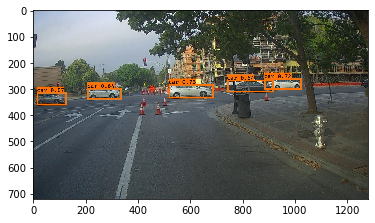

In [0]:
out_scores, out_boxes, out_classes = predict(sess, "0005.jpg")

Found 1 boxes for 0015.jpg
truck 0.72 (714, 275) (1086, 387)


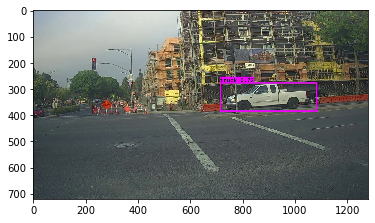

In [0]:
out_scores, out_boxes, out_classes = predict(sess, "0015.jpg")

Found 2 boxes for 0045.jpg
traffic light 0.70 (383, 40) (416, 101)
traffic light 0.73 (569, 32) (604, 102)


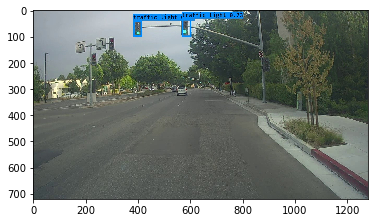

In [0]:
out_scores, out_boxes, out_classes = predict(sess, "0045.jpg")

# Prediction Video
If we were to run our session in a for loop over all our images. Here's what we would get:

[pred_video.mp4](https://github.com/adnaneaabbar/car-detection/tree/master/assets/videos/pred_video.mp4)


**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's GitHub repository. The pre-trained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

**Car detection dataset**:
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. We are grateful to Brody Huval, Chih Hu and Rahul Patel for  providing this data. 